# CIFAR10 Data Augmentation Experiments with ResNet18
This assignment explores the benefits of different data augmentation techniques (Mixup, Cutout, Standard)
on the learning performance of a ResNet18 model trained on a subset of CIFAR10.



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset

dataset = load_dataset('cifar10')

def format_data(split):
    images = np.array(split["img"])
    labels = np.array(split["label"])
    images = images.transpose(0, 3, 1, 2).astype(np.float32) / 255.0
    mean = images.mean(axis=(2, 3), keepdims=True)
    std = images.std(axis=(2, 3), keepdims=True)
    std[std == 0] = 1.0
    images = (images - mean) / std
    return images, labels

X_train_full, y_train_full = format_data(dataset["train"])
X_test, y_test = format_data(dataset["test"])

train_idxs = []
for i in range(10):
    class_idxs = np.where(y_train_full == i)[0]
    sampled_idxs = np.random.choice(class_idxs, 1000, replace=False)
    train_idxs.append(sampled_idxs)
train_idxs = np.concatenate(train_idxs)
np.random.shuffle(train_idxs)

X_train = X_train_full[train_idxs]
y_train = y_train_full[train_idxs]

## 1. Model and Training Loop Setup



In [4]:
def ResNetModel():
    model = torchvision.models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

def train_one_epoch(model, loader, optimizer, criterion, device, augmentation_fn=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        if augmentation_fn:
            inputs.requires_grad = True
            inputs, targets = augmentation_fn(inputs, targets)

        optimizer.zero_grad()
        outputs = model(inputs)

        if targets.dim() > 1:
            loss = criterion(outputs, targets)
        else:
            loss = criterion(outputs, targets)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_acc = 100. * correct / total if total > 0 else 0
    return running_loss / len(loader), epoch_acc

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return 100. * correct / total

def train_model_aug(augmentation_fn=None, epochs=10, lr=0.001):
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    model = ResNetModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    def criterion(outputs, targets):
        if targets.dim() > 1:
            return torch.mean(torch.sum(-targets * F.log_softmax(outputs, dim=1), dim=1))
        return F.cross_entropy(outputs, targets)

    train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).long())
    test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).long())

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=100, shuffle=False)

    report_loader = DataLoader(train_ds, batch_size=100, shuffle=False)

    history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

    for epoch in range(epochs):
        loss, _ = train_one_epoch(model, train_loader, optimizer, criterion, device, augmentation_fn)
        train_acc = evaluate(model, report_loader, device)
        test_acc = evaluate(model, test_loader, device)

        history['train_loss'].append(loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    return history



## 2. Data Augmentation Implementations



In [5]:
def mixup_aug(inputs, targets, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = inputs.size(0)
    index = torch.randperm(batch_size).to(inputs.device)

    mixed_x = lam * inputs + (1 - lam) * inputs[index, :]

    y_a = F.one_hot(targets, 10).float()
    y_b = F.one_hot(targets[index], 10).float()
    mixed_y = lam * y_a + (1 - lam) * y_b

    return mixed_x, mixed_y

def cutout_aug(inputs, K=16):
    outputs = inputs.clone()
    batch_size, channels, h, w = outputs.shape

    for i in range(batch_size):
        if np.random.rand() > 0.5:
            center_h = np.random.randint(0, h)
            center_w = np.random.randint(0, w)

            y1 = np.clip(center_h - K // 2, 0, h)
            y2 = np.clip(center_h + K // 2, 0, h)
            x1 = np.clip(center_w - K // 2, 0, w)
            x2 = np.clip(center_w + K // 2, 0, w)

            outputs[i, :, y1:y2, x1:x2] = 0

    return outputs

def standard_aug(inputs, K=4):
    batch_size, channels, h, w = inputs.shape
    outputs = inputs.clone()

    flip = torch.rand(batch_size) > 0.5
    outputs[flip] = torch.flip(outputs[flip], dims=[3])

    padded = F.pad(outputs, (K, K, K, K), mode='constant', value=0)
    final_outputs = torch.zeros_like(outputs)

    for i in range(batch_size):
        k1 = np.random.randint(0, 2*K + 1)
        k2 = np.random.randint(0, 2*K + 1)
        final_outputs[i] = padded[i, :, k1:k1+h, k2:k2+w]

    return final_outputs

def get_mixup_fn(alpha):
    return lambda x, y: mixup_aug(x, y, alpha)

def cutout_fn(x, y):
    return cutout_aug(x, K=16), y

def standard_fn(x, y):
    return standard_aug(x, K=4), y

def combined_fn(alpha):
    def augment(x, y):
        x_aug, y_aug = standard_fn(x, y)
        x_aug, y_aug = cutout_fn(x_aug, y_aug)
        return mixup_aug(x_aug, y_aug, alpha)
    return augment



### Task 1: No Augmentation


In [6]:
print("Task 1: No Augmentation")
history_none = train_model_aug(augmentation_fn=None)



Task 1: No Augmentation
Epoch 1/10 - Loss: 1.8315, Train Acc: 44.71%, Test Acc: 39.13%
Epoch 2/10 - Loss: 1.3948, Train Acc: 55.43%, Test Acc: 48.00%
Epoch 3/10 - Loss: 1.1607, Train Acc: 66.40%, Test Acc: 53.89%
Epoch 4/10 - Loss: 0.9781, Train Acc: 71.46%, Test Acc: 55.83%
Epoch 5/10 - Loss: 0.8349, Train Acc: 77.49%, Test Acc: 58.06%
Epoch 6/10 - Loss: 0.6824, Train Acc: 81.24%, Test Acc: 56.83%
Epoch 7/10 - Loss: 0.5530, Train Acc: 83.08%, Test Acc: 57.23%
Epoch 8/10 - Loss: 0.4350, Train Acc: 86.26%, Test Acc: 56.33%
Epoch 9/10 - Loss: 0.3581, Train Acc: 89.42%, Test Acc: 58.39%
Epoch 10/10 - Loss: 0.2826, Train Acc: 93.50%, Test Acc: 58.41%


### Task 2: Mixup Augmentation ($\alpha=0.2, 0.4$)


In [7]:
print("\nTask 2: Mixup (alpha=0.2)")
history_mixup_02 = train_model_aug(augmentation_fn=get_mixup_fn(0.2))

print("\nTask 2: Mixup (alpha=0.4)")
history_mixup_04 = train_model_aug(augmentation_fn=get_mixup_fn(0.4))


Task 2: Mixup (alpha=0.2)
Epoch 1/10 - Loss: 1.9586, Train Acc: 47.37%, Test Acc: 42.44%
Epoch 2/10 - Loss: 1.6191, Train Acc: 53.79%, Test Acc: 47.72%
Epoch 3/10 - Loss: 1.4325, Train Acc: 51.98%, Test Acc: 43.64%
Epoch 4/10 - Loss: 1.3175, Train Acc: 69.18%, Test Acc: 56.08%
Epoch 5/10 - Loss: 1.2111, Train Acc: 70.91%, Test Acc: 54.06%
Epoch 6/10 - Loss: 1.0984, Train Acc: 81.26%, Test Acc: 59.34%
Epoch 7/10 - Loss: 0.9855, Train Acc: 79.80%, Test Acc: 56.59%
Epoch 8/10 - Loss: 0.9380, Train Acc: 84.49%, Test Acc: 57.88%
Epoch 9/10 - Loss: 0.8260, Train Acc: 82.57%, Test Acc: 56.24%
Epoch 10/10 - Loss: 0.8318, Train Acc: 86.54%, Test Acc: 55.21%

Task 2: Mixup (alpha=0.4)
Epoch 1/10 - Loss: 1.9665, Train Acc: 43.55%, Test Acc: 41.00%
Epoch 2/10 - Loss: 1.6969, Train Acc: 58.24%, Test Acc: 51.13%
Epoch 3/10 - Loss: 1.5704, Train Acc: 62.15%, Test Acc: 52.20%
Epoch 4/10 - Loss: 1.4530, Train Acc: 69.87%, Test Acc: 56.39%
Epoch 5/10 - Loss: 1.3939, Train Acc: 74.11%, Test Acc: 57.47%


### Task 3: Cutout Augmentation ($K=16$)


In [8]:
print("\nTask 3: Cutout (K=16)")
history_cutout = train_model_aug(augmentation_fn=cutout_fn)


Task 3: Cutout (K=16)
Epoch 1/10 - Loss: 1.9123, Train Acc: 44.02%, Test Acc: 40.88%
Epoch 2/10 - Loss: 1.5158, Train Acc: 53.40%, Test Acc: 48.60%
Epoch 3/10 - Loss: 1.3216, Train Acc: 60.37%, Test Acc: 52.85%
Epoch 4/10 - Loss: 1.1901, Train Acc: 62.92%, Test Acc: 51.82%
Epoch 5/10 - Loss: 1.0639, Train Acc: 73.21%, Test Acc: 58.87%
Epoch 6/10 - Loss: 0.9472, Train Acc: 71.18%, Test Acc: 54.40%
Epoch 7/10 - Loss: 0.8407, Train Acc: 76.29%, Test Acc: 58.54%
Epoch 8/10 - Loss: 0.7672, Train Acc: 80.60%, Test Acc: 58.70%
Epoch 9/10 - Loss: 0.6893, Train Acc: 86.08%, Test Acc: 61.46%
Epoch 10/10 - Loss: 0.6248, Train Acc: 81.23%, Test Acc: 56.77%


### Task 4: Standard Augmentation ($K=4$)


In [9]:
print("\nTask 4: Standard (K=4)")
history_standard = train_model_aug(augmentation_fn=standard_fn)




Task 4: Standard (K=4)
Epoch 1/10 - Loss: 1.9605, Train Acc: 40.55%, Test Acc: 40.32%
Epoch 2/10 - Loss: 1.6035, Train Acc: 42.16%, Test Acc: 40.37%
Epoch 3/10 - Loss: 1.4570, Train Acc: 49.45%, Test Acc: 47.51%
Epoch 4/10 - Loss: 1.3557, Train Acc: 58.05%, Test Acc: 54.61%
Epoch 5/10 - Loss: 1.2532, Train Acc: 60.59%, Test Acc: 56.11%
Epoch 6/10 - Loss: 1.1916, Train Acc: 60.39%, Test Acc: 56.19%
Epoch 7/10 - Loss: 1.1388, Train Acc: 63.23%, Test Acc: 59.32%
Epoch 8/10 - Loss: 1.0834, Train Acc: 65.65%, Test Acc: 59.93%
Epoch 9/10 - Loss: 1.0336, Train Acc: 70.29%, Test Acc: 63.16%
Epoch 10/10 - Loss: 0.9904, Train Acc: 67.42%, Test Acc: 61.54%


### Task 5: Combined Augmentation


In [10]:
best_alpha = 0.2 if history_mixup_02['test_acc'][-1] > history_mixup_04['test_acc'][-1] else 0.4
print(f"\nTask 5: Combined (Standard + Cutout + Mixup alpha={best_alpha})")
history_combined = train_model_aug(augmentation_fn=combined_fn(best_alpha))




Task 5: Combined (Standard + Cutout + Mixup alpha=0.4)
Epoch 1/10 - Loss: 2.1368, Train Acc: 36.84%, Test Acc: 35.92%
Epoch 2/10 - Loss: 1.9158, Train Acc: 42.98%, Test Acc: 42.43%
Epoch 3/10 - Loss: 1.8239, Train Acc: 47.26%, Test Acc: 46.72%
Epoch 4/10 - Loss: 1.7601, Train Acc: 53.71%, Test Acc: 51.97%
Epoch 5/10 - Loss: 1.7278, Train Acc: 55.67%, Test Acc: 53.31%
Epoch 6/10 - Loss: 1.6697, Train Acc: 49.60%, Test Acc: 47.36%
Epoch 7/10 - Loss: 1.6404, Train Acc: 54.70%, Test Acc: 51.96%
Epoch 8/10 - Loss: 1.6427, Train Acc: 57.92%, Test Acc: 54.09%
Epoch 9/10 - Loss: 1.5851, Train Acc: 65.08%, Test Acc: 61.08%
Epoch 10/10 - Loss: 1.5996, Train Acc: 67.30%, Test Acc: 62.70%


## 4. Results and Plots



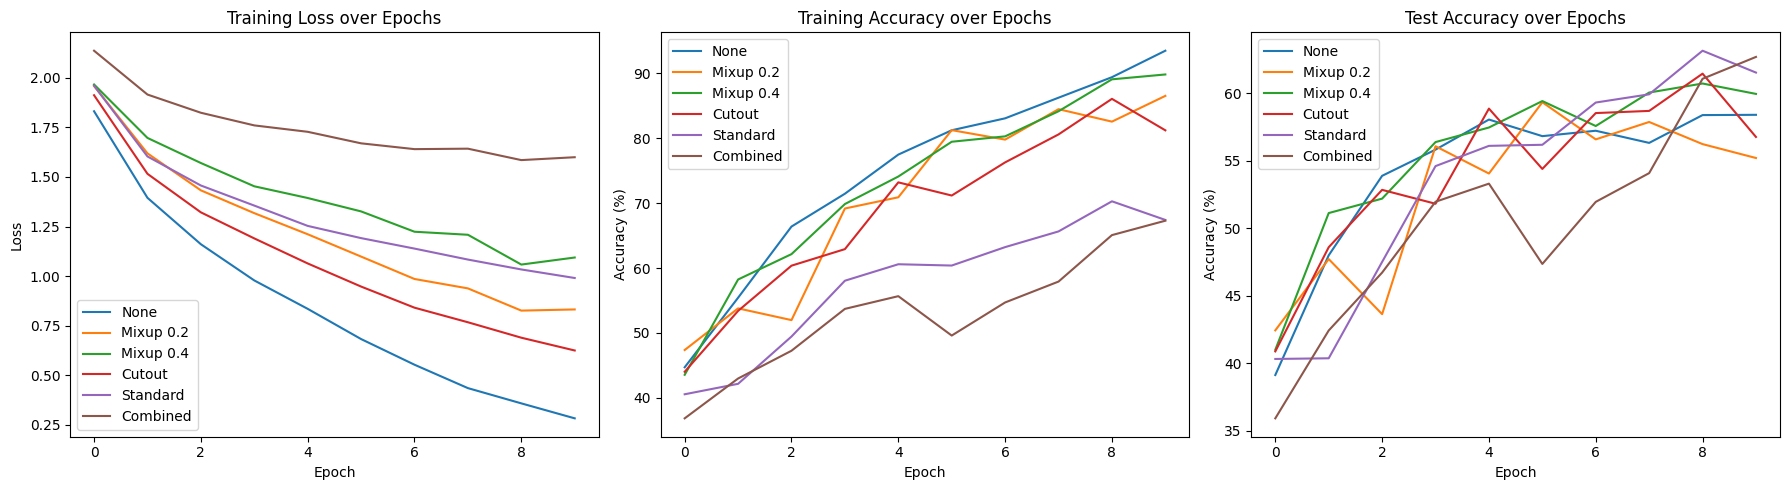

Final Test Accuracy for None: 58.41%
Final Test Accuracy for Mixup 0.2: 55.21%
Final Test Accuracy for Mixup 0.4: 59.96%
Final Test Accuracy for Cutout: 56.77%
Final Test Accuracy for Standard: 61.54%
Final Test Accuracy for Combined: 62.70%


In [11]:
def plot_results(histories, titles):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Training Loss
    for i, hist in enumerate(histories):
        axes[0].plot(hist['train_loss'], label=titles[i])
    axes[0].set_title('Training Loss over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Training Accuracy
    for i, hist in enumerate(histories):
        axes[1].plot(hist['train_acc'], label=titles[i])
    axes[1].set_title('Training Accuracy over Epochs')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()

    # Test Accuracy
    for i, hist in enumerate(histories):
        axes[2].plot(hist['test_acc'], label=titles[i])
    axes[2].set_title('Test Accuracy over Epochs')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy (%)')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

histories = [
    history_none,
    history_mixup_02,
    history_mixup_04,
    history_cutout,
    history_standard,
    history_combined
]
titles = [
    'None',
    'Mixup 0.2',
    'Mixup 0.4',
    'Cutout',
    'Standard',
    'Combined'
]

plot_results(histories, titles)

# Recording final test accuracy
for title, hist in zip(titles, histories):
    print(f"Final Test Accuracy for {title}: {hist['test_acc'][-1]:.2f}%")
